In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.decomposition import NMF

In [3]:
from playervectors import PlayerHeatMap
from ExtractData import ExtractCoordinates, ExtractPlayers, ExtractTeams, ExtractMinutesPlayed

## Load: Event Streams

In [4]:
df_events = pd.read_csv('event_streams/events_Germany.csv')
df_events.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tagsList,pos_orig_y,pos_orig_x,pos_dest_y,pos_dest_x
0,8,Simple pass,[{'id': 1801}],15231,"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",2516739,Pass,2446,1H,2.409746,85.0,179896442,[1801],50,50,48,50
1,8,Simple pass,[{'id': 1801}],14786,"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",2516739,Pass,2446,1H,2.506082,85.0,179896443,[1801],48,50,22,22
2,8,Simple pass,[{'id': 1801}],14803,"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",2516739,Pass,2446,1H,6.946706,85.0,179896444,[1801],22,22,46,6
3,8,Simple pass,[{'id': 1801}],14768,"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",2516739,Pass,2446,1H,10.786491,85.0,179896445,[1801],46,6,10,20
4,8,Simple pass,[{'id': 1801}],14803,"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",2516739,Pass,2446,1H,12.684514,85.0,179896446,[1801],10,20,4,27


#### Normalize Playing Direction

In [5]:
# Trivial hard-coded approach
def normalize_direction(df: pd.DataFrame) -> pd.DataFrame:
    # Update rows where pos_dest_x - pos_orig_x < 0
    condition1 = (df['pos_orig_x'] > df['pos_dest_x'])
    condition2 = (df['pos_orig_y'] > df['pos_dest_y'])

    # cond = condition1
    cond = condition1 | condition2
    df.loc[cond, 'pos_orig_x'] = 100 - df.loc[cond, 'pos_orig_x']
    df.loc[cond, 'pos_orig_y'] = 101 - df.loc[cond, 'pos_orig_y']
    return df

In [6]:
df_events = normalize_direction(df_events)

#### Select Relevant Actions with respect to thier x,y coordinates


In [7]:
# {action -> {playerID -> ([list of x coordinates], [list of y coordinates])}}
# We select here: Shot, Pass, Cross, Duell
coordinates = ExtractCoordinates(df=df_events, column_player_id='playerId', column_event_name='subEventName', column_x='pos_orig_x', column_y='pos_orig_y', actions=['Shot', 'Simple pass', 'Cross', 'Ground attacking duel'])

## Load: Players

In [8]:
df_players = pd.read_csv('event_streams/players.csv')
df_players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,NaN,Tekin,4502.0,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687.0
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,NaN,Sarr,3775.0,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423.0
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,NaN,Mandanda,3772.0,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,NaN,O. Mandanda,NaN
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,NaN,N'Diaye,683.0,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314.0
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,NaN,Konat\u00e9,2975.0,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,NaN


#### Extract Player Information

In [9]:
# Extract Players
# Mapping {playerID -> [list of selected attributes]}
players = ExtractPlayers(df=df_players, wy_id='wyId', attributes=['firstName', 'lastName', 'currentTeamId'])

In [10]:
df_playerank = pd.read_csv('event_streams/playerank.csv')
df_playerank.head()

,goalScored,playerankScore,matchId,playerId,roleCluster,minutesPlayed
0,0,0.0053,2057991,10014,right CB,90
1,0,0.0009,2057992,10014,right CB,41
2,0,-0.0013,2057998,100140,central MF,90
3,0,0.0031,2058000,100140,left CB,90
4,0,0.0035,2499869,10108,right CB,90


#### Extract Played Minutes

In [11]:
# Extract played minutes
# Mapping {playerID -> minutes}
minutes_played = ExtractMinutesPlayed(df=df_playerank, column_player='playerId', column_minutes='minutesPlayed')

## Load: Teams

In [12]:
df_teams = pd.read_csv('event_streams/teams.csv')
df_teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


#### Extract Team Information

In [13]:
# Extracting Team Information
# Mapping {teamID -> [selected attributes e.g. TeamName, City, ...]}
teams = ExtractTeams(df=df_teams, wy_id='wyId', attributes=['name'])

In [14]:
# Mapping {teamID -> [list of playerIDs]}
teamID_to_playerIDs = {}

# Mapping {playerID -> Player Name}
playersID_to_name = {}

for playerID, attributes in players.items():
    first, last, teamID = attributes[0], str(attributes[1]), str(attributes[2])
    
    if teamID not in teamID_to_playerIDs:
        teamID_to_playerIDs[teamID] = [playerID]
    else:
        teamID_to_playerIDs[teamID].append(playerID)
    
    if playerID not in playersID_to_name:
        playersID_to_name[playerID] = f'{first} {last}'

## Visualizing Principal Components for Actions: Shot, Cross, Simple pass

### Principal Components for Action: Shot

In [15]:
# Hyperparameters
M, N = 50, 50

k = 1
sigma = 8.0
action = 'Shot'
playerID_to_heatmap = {}
for playerID, pairXY in list(coordinates[action].items()):
    x, y = pairXY[0], pairXY[1] 

    # Check for played minutes 
    minutes = 0.0 
    if playerID in minutes_played: 
        minutes = minutes_played[playerID] 

    # Check for player name
    player_name = None
    if playerID in playersID_to_name:
        player_name = playersID_to_name[playerID]

    # Build Player-Vectors
    heatmap = PlayerHeatMap(shape=(M, N),
                            player_name=player_name,
                            player_id=playerID,
                            action_name=action,
                            sigma=sigma)
    
    # 1 - 3: Counting + Normalizing + Smoothing
    heatmap.fit(x, y, minutes)

    playerID_to_heatmap[playerID] = heatmap

In [16]:
# 4 Shot components
k_components = 4
num_players = len(playerID_to_heatmap)

# In the paper this is done by using a matrix called M, i call it A
A = []

# Calculate A
for _, X in playerID_to_heatmap.items():
    X_reshape = X.heatmap_.reshape(M * N, 1)
    A.append(X_reshape)
A = np.array(A).reshape(num_players, N * M)

In [17]:
print(f'Number of Players: {num_players}')
print(f'A shape: {A.shape}')

Number of Players: 392
A shape: (392, 2500)


#### Using NMF

In [18]:
model = NMF(n_components=k_components, init='random', random_state=0)
W = model.fit_transform(A)
H = model.components_

In [19]:
print(f'Shape of W: {W.shape}')
print(f'Shape of H: {H.shape}')

Shape of W: (392, 4)
Shape of H: (4, 2500)


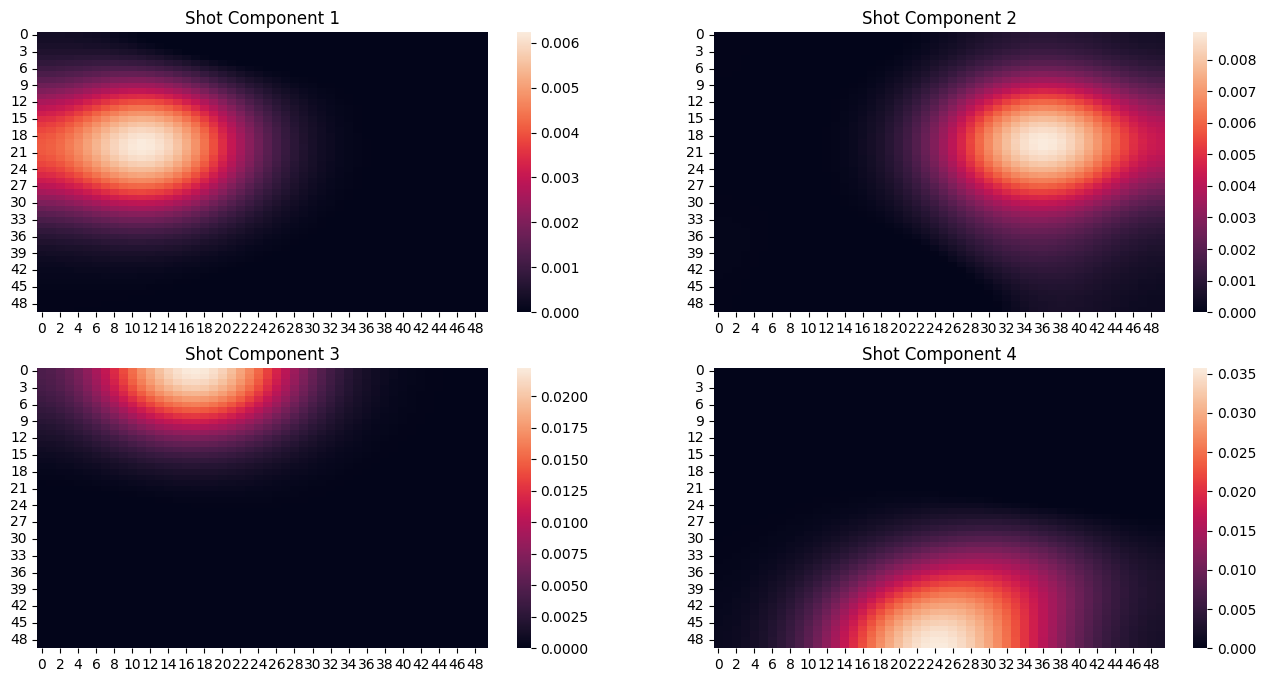

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
for k in range(k_components):
    H_k = H[k]
    H_k = H_k.reshape(N, M)
    ax = axes[k // 2, k % 2]
    sns.heatmap(H_k, ax=ax, cbar=True)
    ax.set_title(f'{action} Component {k + 1}')
plt.show()

### Principle Components for Action: Cross

In [21]:
# Hyperparameters
M, N = 50, 50

k = 1
sigma = 8.0
action = 'Cross'
playerID_to_heatmap = {}
for playerID, pairXY in list(coordinates[action].items()):
    x, y = pairXY[0], pairXY[1] 

    # Check for played minutes 
    minutes = 0.0 
    if playerID in minutes_played: 
        minutes = minutes_played[playerID] 

    # Check for player name
    player_name = None
    if playerID in playersID_to_name:
        player_name = playersID_to_name[playerID]

    # Build Player-Vectors
    heatmap = PlayerHeatMap(shape=(M, N),
                            player_name=player_name,
                            player_id=playerID,
                            action_name=action,
                            sigma=sigma)
    
    # 1 - 3: Counting + Normalizing + Smoothing
    heatmap.fit(x, y, minutes)

    playerID_to_heatmap[playerID] = heatmap

In [22]:
# 4 Shot components
k_components = 4
num_players = len(playerID_to_heatmap)

# In the paper this is done by using a matrix called M, i call it A
A = []

# Calculate A
for _, X in playerID_to_heatmap.items():
    X_reshape = X.heatmap_.reshape(M * N, 1)
    A.append(X_reshape)
A = np.array(A).reshape(num_players, N * M)

In [23]:
model = NMF(n_components=k_components, init='random', random_state=0)
W = model.fit_transform(A)
H = model.components_

In [24]:
print(f'Number of Players: {num_players}')
print(f'A shape: {A.shape}')

Number of Players: 373
A shape: (373, 2500)


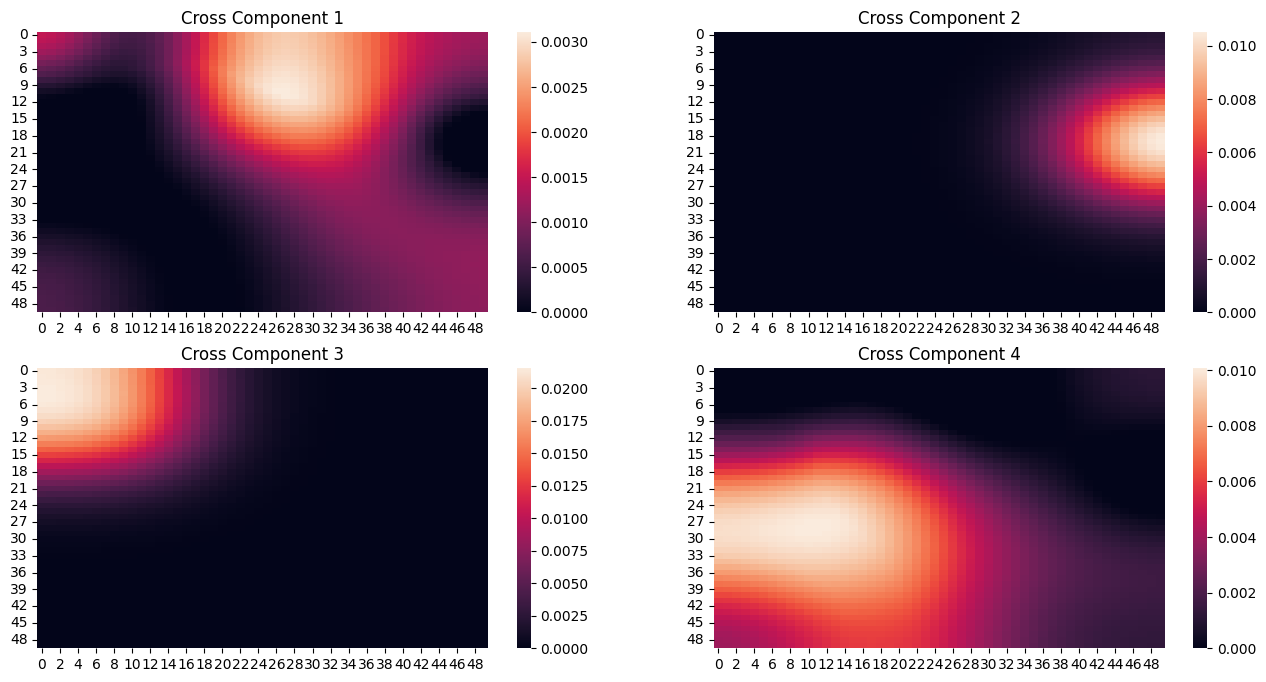

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
for k in range(k_components):
    H_k = H[k]
    H_k = H_k.reshape(N, M)
    ax = axes[k // 2, k % 2]
    sns.heatmap(H_k, ax=ax, cbar=True)
    ax.set_title(f'{action} Component {k + 1}')
plt.show()

### Principle Components for Action: Simple pass

In [26]:
# Hyperparameters
M, N = 50, 50

k = 1
sigma = 9.0
action = 'Simple pass'
playerID_to_heatmap = {}
for playerID, pairXY in list(coordinates[action].items()):
    x, y = pairXY[0], pairXY[1] 

    # Check for played minutes 
    minutes = 0.0 
    if playerID in minutes_played: 
        minutes = minutes_played[playerID] 

    # Check for player name
    player_name = None
    if playerID in playersID_to_name:
        player_name = playersID_to_name[playerID]

    # Build Player-Vectors
    heatmap = PlayerHeatMap(shape=(M, N),
                            player_name=player_name,
                            player_id=playerID,
                            action_name=action,
                            sigma=sigma)
    
    # 1 - 3: Counting + Normalizing + Smoothing
    heatmap.fit(x, y, minutes)

    playerID_to_heatmap[playerID] = heatmap

In [27]:
# 4 Shot components
k_components = 4
num_players = len(playerID_to_heatmap)

# In the paper this is done by using a matrix called M, i call it A
A = []

# Calculate A
for _, X in playerID_to_heatmap.items():
    X_reshape = X.heatmap_.reshape(M * N, 1)
    A.append(X_reshape)
A = np.array(A).reshape(num_players, N * M)

In [28]:
model = NMF(n_components=k_components, init='random', random_state=0)
W = model.fit_transform(A)
H = model.components_

/opt/homebrew/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [29]:
print(f'Number of Players: {num_players}')
print(f'A shape: {A.shape}')

Number of Players: 472
A shape: (472, 2500)


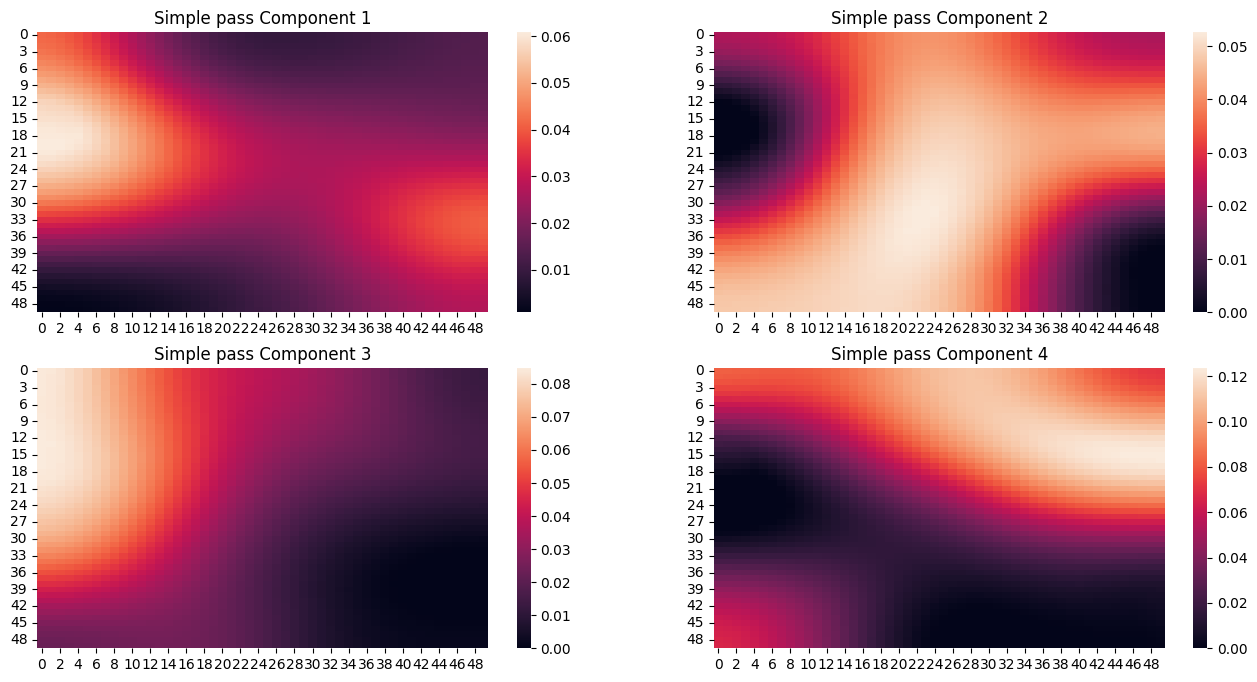

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
for k in range(k_components):
    H_k = H[k]
    H_k = H_k.reshape(N, M)
    ax = axes[k // 2, k % 2]
    sns.heatmap(H_k, ax=ax, cbar=True)
    ax.set_title(f'{action} Component {k + 1}')
plt.show()